# Imports

In [1]:
pip install xgboost[gpu]

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import xgboost as xgb

from PIL import Image

# Set Random Seed

In [3]:
import random
random.seed(7)

np.random.seed(7)

# Create Patches

In [4]:
with open('/content/drive/My Drive/thesis/naip_chm_mask_3d.pkl', 'rb') as f:
    naip_chm_mask_3d = pickle.load(f)
    naip_chm_mask_3d = naip_chm_mask_3d[:,:,1]
    print(naip_chm_mask_3d.shape)

(10569, 11250)


In [5]:
# load the image
naip_natural_tiff = Image.open('/content/drive/MyDrive/thesis/training_images/naip_natural_.tif')

naip_natural_array = np.array(naip_natural_tiff)
print(naip_natural_array.shape)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (118901250 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(10569, 11250, 3)


In [6]:
binary_mask = np.where(naip_chm_mask_3d, 255, 0)

In [7]:
pixels = naip_natural_array.reshape(-1, naip_natural_array.shape[2])
zero_pixels_mask = np.all(pixels == 0, axis=-1)
pixels = pixels[~zero_pixels_mask]

binary_labels = (binary_mask.flatten() > 128).astype(int)
binary_labels = binary_labels[~zero_pixels_mask]

# Modeling

## Grid Search

In [ ]:
# # split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(pixels, binary_labels, test_size=0.2, random_state=42)

# model = xgb.XGBClassifier(device = "cuda")

# # parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [5, 6, 9, 12],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 0.9, 1.0]
# }

# # grid search
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

# grid_search.fit(X_train, y_train)

In [9]:
# print("Best parameters found: ", grid_search.best_params_)
# print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 50, 'subsample': 0.8}
Best accuracy found:  0.9134511010115781


## Train XGBoost

In [8]:
X_train, X_test, y_train, y_test = train_test_split(pixels, binary_labels, test_size=0.3, random_state=42)

# xgboost
model = xgb.XGBClassifier(
    subsample = 0.8,
    n_estimators = 50,
    max_depth = 9,
    learning_rate = 0.1,
    device = "cuda"
)

# Train the model
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Evaluate Model

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:43:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


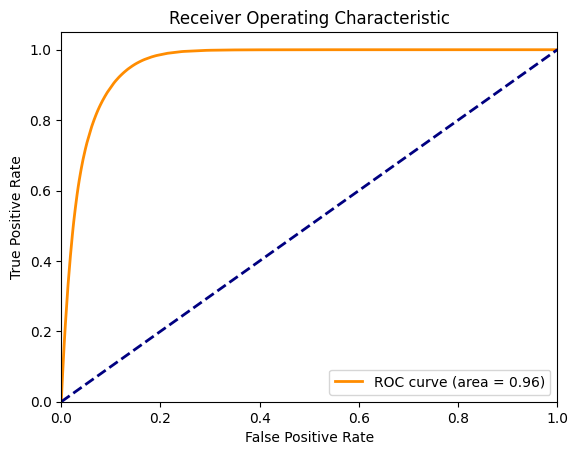

In [9]:
# predict probabilities for the test set
y_probs = model.predict_proba(X_test)[:, 1]  # probabilities for the positive class

# calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
# method 1: Youden’s J statistic
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

# method 2: Minimizing the Euclidean distance to the top-left corner
distance = np.sqrt((1-tpr)**2 + fpr**2)
optimal_idx_distance = np.argmin(distance)
optimal_threshold_distance = thresholds[optimal_idx_distance]

print(f'Optimal threshold by Youden’s J: {optimal_threshold}')
print(f'Optimal threshold by Euclidean Distance: {optimal_threshold_distance}')

Optimal threshold by Youden’s J: 0.17223261296749115
Optimal threshold by Euclidean Distance: 0.23130887746810913


In [11]:
print(classification_report(y_test, y_probs>optimal_threshold_distance))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93  21184293
           1       0.61      0.92      0.73   4145514

    accuracy                           0.89  25329807
   macro avg       0.80      0.90      0.83  25329807
weighted avg       0.92      0.89      0.90  25329807

